In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import fsolve

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


## DATA

In [4]:
title = "LQ down 800 GeV"

In [5]:
##############
# input data #
##############

# b1,b2 -> (pT, eta, phi) from the leading and second b-tagged jets
# tau -> (pT, eta, phi) from the tau
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, num_jets, num_btag)  HT: sum PT of all the jets, number of jets (b-tag or not), number of b-tagged jets


################
# New Physics: #
################

datFolderNP = '../DATA/signal/dats-LQdown-800GeV/'
k_LQdown = 1.8247261601649074
crossfidNP = 0.7085123999999999*k_LQdown

b1_NP = np.loadtxt(datFolderNP + 'b1.dat', delimiter=' ')
b2_NP = np.loadtxt(datFolderNP + 'b2.dat', delimiter=' ')
tau_NP = np.loadtxt(datFolderNP + 'tau.dat', delimiter=' ')
MET_NP = np.loadtxt(datFolderNP + 'MET.dat', delimiter=' ')
hadinfo_NP = np.loadtxt(datFolderNP + 'hadinfo.dat', delimiter=' ')

print('# eventos LQ: ', len(b1_NP))



###############
# Background: #
###############

# tt and fakett

datFolderSM_tt = '../DATA/background/dats-tt/'

k_fakett = 1.1053030485310749
crossfid_fakett = 0.19136
k_tt = 1.2593273872014419
crossfid_tt = (5.1373984*k_tt) + (crossfid_fakett * k_fakett)

b1_SM_tt = np.loadtxt(datFolderSM_tt + 'b1.dat', delimiter=' ')
b2_SM_tt = np.loadtxt(datFolderSM_tt + 'b2.dat', delimiter=' ')
tau_SM_tt = np.loadtxt(datFolderSM_tt + 'tau.dat', delimiter=' ')
MET_SM_tt = np.loadtxt(datFolderSM_tt + 'MET.dat', delimiter=' ')
hadinfo_SM_tt = np.loadtxt(datFolderSM_tt + 'hadinfo.dat', delimiter=' ')

print('# eventos tt: ', len(b1_SM_tt))


# singlet part 1

datFolderSM_singletP1 = '../DATA/background/dats-singletP1/'
k_singletTOTAL = 3.440676833094312 # it is the total k_singlet
crossfid_singletP1 = 0.39648*k_singletTOTAL

b1_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'b1.dat', delimiter=' ')
b2_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'b2.dat', delimiter=' ')
tau_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'tau.dat', delimiter=' ')
MET_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'MET.dat', delimiter=' ')
hadinfo_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'hadinfo.dat', delimiter=' ')

print('# eventos singlet part 1: ', len(b1_SM_singletP1))


# singlet part 2

datFolderSM_singletP2 = '../DATA/background/dats-singlet-comp/'
k_singletTOTAL = 3.440676833094312 # it is the total k_singlet
crossfid_singletP2 = 0.283008*k_singletTOTAL

b1_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'b1.dat', delimiter=' ')
b2_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'b2.dat', delimiter=' ')
tau_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'tau.dat', delimiter=' ')
MET_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'MET.dat', delimiter=' ')
hadinfo_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'hadinfo.dat', delimiter=' ')

print('# eventos singlet part 2: ', len(b1_SM_singletP2))


# Wbbjets

datFolderSM_Wbbjets = '../DATA/background/dats-Wbbjets/'
k_wjets = 0.9781509289273502
crossfid_Wbbjets = 0.9988452079186325*k_wjets

b1_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'b1.dat', delimiter=' ')
b2_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'b2.dat', delimiter=' ')
tau_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'tau.dat', delimiter=' ')
MET_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'MET.dat', delimiter=' ')
hadinfo_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'hadinfo.dat', delimiter=' ')

print('# eventos Wbbjets: ', len(b1_SM_Wbbjets))


# ttW (part of ttV)

datFolderSM_ttW = '../DATA/background/dats-ttW/'
k_ttV = 3.056401327463198 # it is the total ttV
crossfid_ttW = 0.0231785208*k_ttV

b1_SM_ttW = np.loadtxt(datFolderSM_ttW + 'b1.dat', delimiter=' ')
b2_SM_ttW = np.loadtxt(datFolderSM_ttW + 'b2.dat', delimiter=' ')
tau_SM_ttW = np.loadtxt(datFolderSM_ttW + 'tau.dat', delimiter=' ')
MET_SM_ttW = np.loadtxt(datFolderSM_ttW + 'MET.dat', delimiter=' ')
hadinfo_SM_ttW = np.loadtxt(datFolderSM_ttW + 'hadinfo.dat', delimiter=' ')

print('# eventos ttW: ', len(b1_SM_ttW))


# ttZ

datFolderSM_ttZ = '../DATA/background/dats-ttZ/'
k_ttV = 3.056401327463198 # it is the total ttV
crossfid_ttZ = 0.050087088*k_ttV

b1_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'b1.dat', delimiter=' ')
b2_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'b2.dat', delimiter=' ')
tau_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'tau.dat', delimiter=' ')
MET_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'MET.dat', delimiter=' ')
hadinfo_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'hadinfo.dat', delimiter=' ')

print('# eventos ttZ: ', len(b1_SM_ttZ))


# ttH

datFolderSM_ttH = '../DATA/background/dats-ttH/'
k_ttH = 2.2127445612386474
crossfid_ttH = 0.025004896*k_ttH

b1_SM_ttH = np.loadtxt(datFolderSM_ttH + 'b1.dat', delimiter=' ')
b2_SM_ttH = np.loadtxt(datFolderSM_ttH + 'b2.dat', delimiter=' ')
tau_SM_ttH = np.loadtxt(datFolderSM_ttH + 'tau.dat', delimiter=' ')
MET_SM_ttH = np.loadtxt(datFolderSM_ttH + 'MET.dat', delimiter=' ')
hadinfo_SM_ttH = np.loadtxt(datFolderSM_ttH + 'hadinfo.dat', delimiter=' ')

print('# eventos ttH: ', len(b1_SM_ttH))

# eventos LQ:  462728
# eventos tt:  826022
# eventos singlet part 1:  179677
# eventos singlet part 2:  94219
# eventos Wbbjets:  162448
# eventos ttW:  141919
# eventos ttZ:  16178
# eventos ttH:  12068


In [6]:
# Number of data points (per-class) for the ML classifier
num_data_NP = int(len(b1_NP)-1)
print(' SIGNAL ')
print('# S chosen: ', num_data_NP)



totalcrossSM = crossfid_tt + crossfid_singletP1+crossfid_singletP2 + crossfid_Wbbjets + crossfid_ttW+crossfid_ttZ + crossfid_ttH

num_data_SM_singletP1 = round( num_data_NP * (crossfid_singletP1/totalcrossSM) )
num_data_SM_singletP2 = round( num_data_NP * (crossfid_singletP2/totalcrossSM) )
num_data_SM_Wbbjets = round( num_data_NP * (crossfid_Wbbjets/totalcrossSM) )
num_data_SM_ttW = round( num_data_NP * (crossfid_ttW/totalcrossSM) )
num_data_SM_ttZ = round( num_data_NP * (crossfid_ttZ/totalcrossSM) )
num_data_SM_ttH = round( num_data_NP * (crossfid_ttH/totalcrossSM) )

num_data_SM_tt = num_data_NP - (num_data_SM_singletP1+num_data_SM_singletP2 + num_data_SM_Wbbjets + num_data_SM_ttW+num_data_SM_ttZ + num_data_SM_ttH)

num_data_SM = num_data_SM_tt + num_data_SM_singletP1+num_data_SM_singletP2 + num_data_SM_Wbbjets + num_data_SM_ttW+num_data_SM_ttZ +  num_data_SM_ttH


print('\n BACKGROUND ')
print('# tt chosen: ', num_data_SM_tt)
print('# singletP1 chosen: ', num_data_SM_singletP1)
print('# singletP2 chosen: ', num_data_SM_singletP2)
print('# Wbbjets chosen: ', num_data_SM_Wbbjets)
print('# ttW chosen: ', num_data_SM_ttW)
print('# ttZ chosen: ', num_data_SM_ttZ)
print('# ttH chosen: ', num_data_SM_ttH)

print('\n# total B eventos chosen: ', num_data_SM)



# CHECK IF THE NUMBER OF EVENTS ARE CORRECT
if num_data_SM == num_data_NP and num_data_NP < len(b1_NP) and num_data_SM_tt < len(b1_SM_tt) and num_data_SM_singletP1 < len(b1_SM_singletP1) and num_data_SM_singletP2 < len(b1_SM_singletP2) and num_data_SM_Wbbjets < len(b1_SM_Wbbjets) and num_data_SM_ttW < len(b1_SM_ttW) and num_data_SM_ttZ < len(b1_SM_ttZ) and num_data_SM_ttH < len(b1_SM_ttH):
    print( '\nEverything OK, continue')
else:
    print( '\nThe number of events of each channel not enought, check if you need to generate more')

 SIGNAL 
# S chosen:  462727

 BACKGROUND 
# tt chosen:  300871
# singletP1 chosen:  61432
# singletP2 chosen:  43850
# Wbbjets chosen:  43998
# ttW chosen:  3190
# ttZ chosen:  6894
# ttH chosen:  2492

# total B eventos chosen:  462727

Everything OK, continue


In [7]:
# KEEP ONLY THE NUMBER OF SIGNAL EVENTS THAT WE WILL USE
b1_NP = b1_NP[:num_data_NP]
b2_NP = b2_NP[:num_data_NP]
tau_NP = tau_NP[:num_data_NP]
MET_NP = MET_NP[:num_data_NP]
hadinfo_NP = hadinfo_NP[:num_data_NP]


# CONCATENATE YOUR SELECTED BACKGROUNDS (as many as you want, with the correct proportion)

b1_SM = np.concatenate((b1_SM_tt[:num_data_SM_tt],b1_SM_singletP1[:num_data_SM_singletP1],b1_SM_singletP2[:num_data_SM_singletP2],b1_SM_Wbbjets[:num_data_SM_Wbbjets],b1_SM_ttW[:num_data_SM_ttW],b1_SM_ttZ[:num_data_SM_ttZ],b1_SM_ttH[:num_data_SM_ttH]))
b2_SM = np.concatenate((b2_SM_tt[:num_data_SM_tt],b2_SM_singletP1[:num_data_SM_singletP1],b2_SM_singletP2[:num_data_SM_singletP2],b2_SM_Wbbjets[:num_data_SM_Wbbjets],b2_SM_ttW[:num_data_SM_ttW],b2_SM_ttZ[:num_data_SM_ttZ],b2_SM_ttH[:num_data_SM_ttH]))
tau_SM = np.concatenate((tau_SM_tt[:num_data_SM_tt],tau_SM_singletP1[:num_data_SM_singletP1],tau_SM_singletP2[:num_data_SM_singletP2],tau_SM_Wbbjets[:num_data_SM_Wbbjets],tau_SM_ttW[:num_data_SM_ttW],tau_SM_ttZ[:num_data_SM_ttZ],tau_SM_ttH[:num_data_SM_ttH]))
MET_SM = np.concatenate((MET_SM_tt[:num_data_SM_tt],MET_SM_singletP1[:num_data_SM_singletP1],MET_SM_singletP2[:num_data_SM_singletP2],MET_SM_Wbbjets[:num_data_SM_Wbbjets],MET_SM_ttW[:num_data_SM_ttW],MET_SM_ttZ[:num_data_SM_ttZ],MET_SM_ttH[:num_data_SM_ttH]))
hadinfo_SM = np.concatenate((hadinfo_SM_tt[:num_data_SM_tt],hadinfo_SM_singletP1[:num_data_SM_singletP1],hadinfo_SM_singletP2[:num_data_SM_singletP2],hadinfo_SM_Wbbjets[:num_data_SM_Wbbjets],hadinfo_SM_ttW[:num_data_SM_ttW],hadinfo_SM_ttZ[:num_data_SM_ttZ],hadinfo_SM_ttH[:num_data_SM_ttH]))

del b1_SM_tt
del b2_SM_tt
del tau_SM_tt
del MET_SM_tt
del hadinfo_SM_tt

del b1_SM_singletP1
del b2_SM_singletP1
del tau_SM_singletP1
del MET_SM_singletP1
del hadinfo_SM_singletP1

del b1_SM_singletP2
del b2_SM_singletP2
del tau_SM_singletP2
del MET_SM_singletP2
del hadinfo_SM_singletP2

del b1_SM_Wbbjets
del b2_SM_Wbbjets
del tau_SM_Wbbjets
del MET_SM_Wbbjets
del hadinfo_SM_Wbbjets

del b1_SM_ttW
del b2_SM_ttW
del tau_SM_ttW
del MET_SM_ttW
del hadinfo_SM_ttW

del b1_SM_ttZ
del b2_SM_ttZ
del tau_SM_ttZ
del MET_SM_ttZ
del hadinfo_SM_ttZ

del b1_SM_ttH
del b2_SM_ttH
del tau_SM_ttH
del MET_SM_ttH
del hadinfo_SM_ttH

In [8]:
print('# Background events: ', len(b1_SM))
print('# Signal events: ', len(b1_NP))

# Background events:  462727
# Signal events:  462727


### pdfs

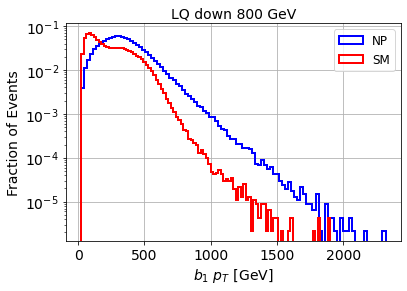

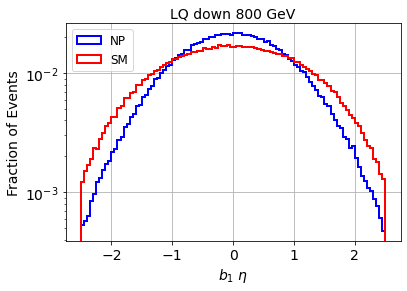

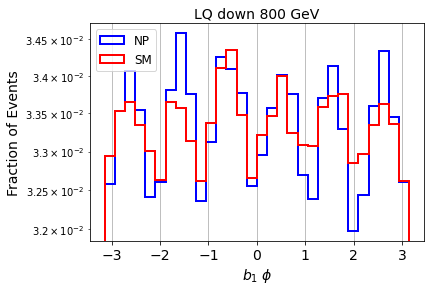

In [9]:
weights = np.ones_like(b1_NP[:,0])/float(len(b1_NP[:,0]))
plt.hist(b1_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,0])/float(len(b1_SM[:,0]))
plt.hist(b1_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(b1_NP[:,1])/float(len(b1_NP[:,1]))
plt.hist(b1_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,1])/float(len(b1_SM[:,1]))
plt.hist(b1_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(b1_NP[:,2])/float(len(b1_NP[:,2]))
plt.hist(b1_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,2])/float(len(b1_SM[:,2]))
plt.hist(b1_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

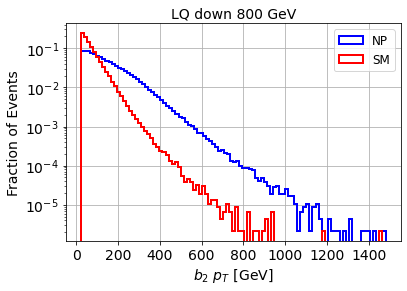

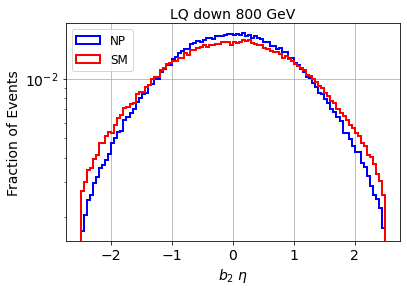

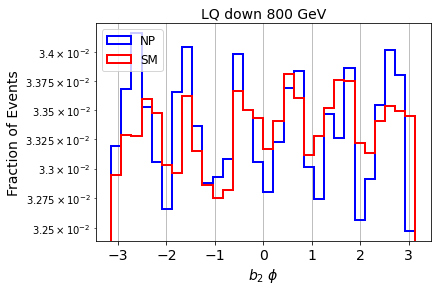

In [10]:
weights = np.ones_like(b2_NP[:,0])/float(len(b2_NP[:,0]))
plt.hist(b2_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,0])/float(len(b2_SM[:,0]))
plt.hist(b2_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(b2_NP[:,1])/float(len(b2_NP[:,1]))
plt.hist(b2_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,1])/float(len(b2_SM[:,1]))
plt.hist(b2_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(b2_NP[:,2])/float(len(b2_NP[:,2]))
plt.hist(b2_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,2])/float(len(b2_SM[:,2]))
plt.hist(b2_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

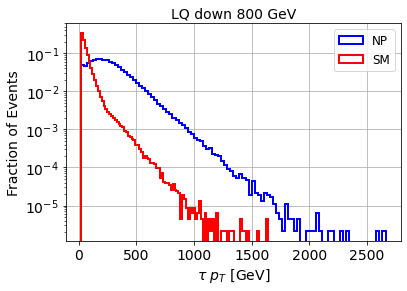

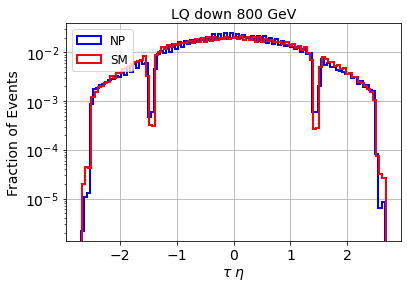

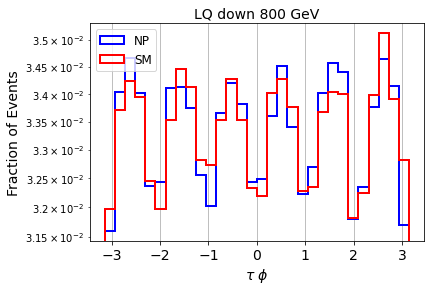

In [11]:
weights = np.ones_like(tau_NP[:,0])/float(len(tau_NP[:,0]))
plt.hist(tau_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,0])/float(len(tau_SM[:,0]))
plt.hist(tau_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(tau_NP[:,1])/float(len(tau_NP[:,1]))
plt.hist(tau_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,1])/float(len(tau_SM[:,1]))
plt.hist(tau_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(tau_NP[:,2])/float(len(tau_NP[:,2]))
plt.hist(tau_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,2])/float(len(tau_SM[:,2]))
plt.hist(tau_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

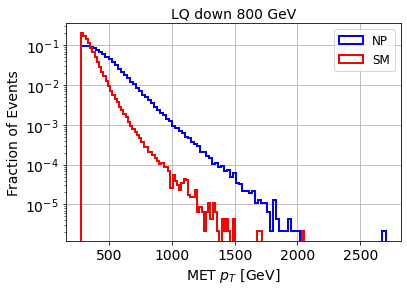

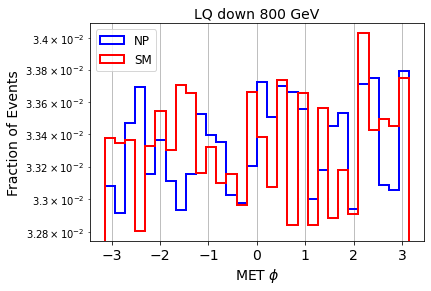

In [12]:
weights = np.ones_like(MET_NP[:,0])/float(len(MET_NP[:,0]))
plt.hist(MET_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(MET_SM[:,0])/float(len(MET_SM[:,0]))
plt.hist(MET_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("MET $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()


weights = np.ones_like(MET_NP[:,2])/float(len(MET_NP[:,2]))
plt.hist(MET_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(MET_SM[:,2])/float(len(MET_SM[:,2]))
plt.hist(MET_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("MET $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

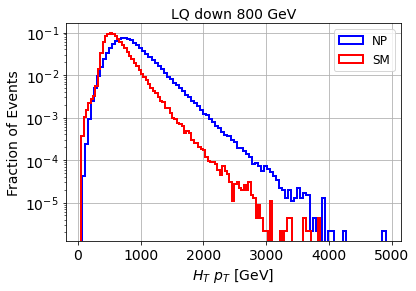

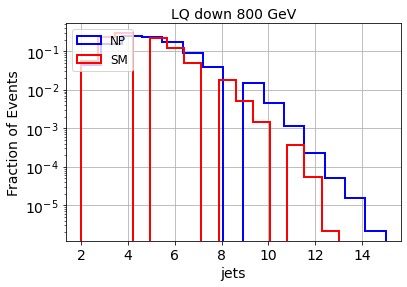

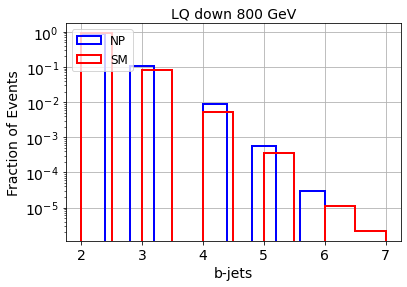

In [13]:
weights = np.ones_like(hadinfo_NP[:,0])/float(len(hadinfo_NP[:,0]))
plt.hist(hadinfo_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,0])/float(len(hadinfo_SM[:,0]))
plt.hist(hadinfo_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$H_T$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(hadinfo_NP[:,1])/float(len(hadinfo_NP[:,1]))
plt.hist(hadinfo_NP[:,1], weights=weights, bins=15, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,1])/float(len(hadinfo_SM[:,1]))
plt.hist(hadinfo_SM[:,1], weights=weights, bins=15, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(hadinfo_NP[:,2])/float(len(hadinfo_NP[:,2]))
plt.hist(hadinfo_NP[:,2], weights=weights, bins=10, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,2])/float(len(hadinfo_SM[:,2]))
plt.hist(hadinfo_SM[:,2], weights=weights, bins=10, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("b-jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

### Train-test-val Dataset

In [14]:
# to normalize
scaler = preprocessing.MinMaxScaler()



df = pd.DataFrame()

df['b1-pt']= np.concatenate([b1_SM[:,0],b1_NP[:,0]])
df['b1-eta']= np.concatenate([b1_SM[:,1],b1_NP[:,1]])
df['b1-phi']= np.concatenate([b1_SM[:,2],b1_NP[:,2]])
# remove the used data
del b1_SM
del b1_NP

df['b2-pt']= np.concatenate([b2_SM[:,0],b2_NP[:,0]])
df['b2-eta']= np.concatenate([b2_SM[:,1],b2_NP[:,1]])
df['b2-phi']= np.concatenate([b2_SM[:,2],b2_NP[:,2]])
# remove the used dat
del b2_SM
del b2_NP

df['tau-pt']= np.concatenate([tau_SM[:,0],tau_NP[:,0]])
df['tau-eta']= np.concatenate([tau_SM[:,1],tau_NP[:,1]])
df['tau-phi']= np.concatenate([tau_SM[:,2],tau_NP[:,2]])
# remove the used data
del tau_SM
del tau_NP

df['MET-pt']= np.concatenate([MET_SM[:,0],MET_NP[:,0]])
df['MET-phi']= np.concatenate([MET_SM[:,2],MET_NP[:,2]])
# remove the used data
del MET_SM
del MET_NP

df['HT-pt']= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[:,0]])
df['num-jets']= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[:,1]])
df['num-bjets']= np.concatenate([hadinfo_SM[:,2],hadinfo_NP[:,2]])
# remove the used data
del hadinfo_SM
del hadinfo_NP

df['Y'] = np.concatenate([np.zeros(num_data_SM),np.ones(num_data_NP)])





# NORMALIZE
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns=['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets','Y'])


# print df to see the data
print(df)


# X and Y for the classifier
X_mon = df[['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets']].values
y_mon = df[['Y']].values


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)


X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)


print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

           b1-pt    b1-eta    b1-phi     b2-pt    b2-eta    b2-phi    tau-pt  \
0       0.010612  0.639656  0.978199  0.003704  0.475990  0.432368  0.005965   
1       0.023802  0.184874  0.496181  0.030635  0.532013  0.058243  0.001994   
2       0.042945  0.628651  0.564290  0.014494  0.573629  0.929822  0.011027   
3       0.102066  0.276110  0.337842  0.087824  0.332533  0.454806  0.025947   
4       0.050260  0.747299  0.141948  0.014892  0.855342  0.447804  0.006188   
...          ...       ...       ...       ...       ...       ...       ...   
925449  0.085410  0.641657  0.533418  0.129256  0.771909  0.411840  0.164526   
925450  0.153698  0.417167  0.648631  0.125291  0.349740  0.135264  0.156161   
925451  0.069220  0.610044  0.453851  0.016635  0.203882  0.810153  0.138958   
925452  0.322289  0.484994  0.485360  0.129633  0.539616  0.955761  0.053639   
925453  0.086137  0.227891  0.501591  0.035711  0.488996  0.964831  0.126798   

         tau-eta   tau-phi    MET-pt   

### XGBoost (per-event)

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.63106	validation_1-logloss:0.63094
[1]	validation_0-logloss:0.58011	validation_1-logloss:0.58000
[2]	validation_0-logloss:0.53764	validation_1-logloss:0.53750
[3]	validation_0-logloss:0.50175	validation_1-logloss:0.50157
[4]	validation_0-logloss:0.47114	validation_1-logloss:0.47102
[5]	validation_0-logloss:0.44504	validation_1-logloss:0.44489
[6]	validation_0-logloss:0.42238	validation_1-logloss:0.42232
[7]	validation_0-logloss:0.40270	validation_1-logloss:0.40263
[8]	validation_0-logloss:0.38554	validation_1-logloss:0.38554
[9]	validation_0-logloss:0.37046	validation_1-logloss:0.37058
[10]	validation_0-logloss:0.35727	validation_1-logloss:0.35742
[11]	validation_0-logloss:0.34560	validation_1-logloss:0.34582
[12]	validation_0-logloss:0.33537	validation_1-logloss:0.33564
[13]	validation_0-logloss:0.32641	validation_1-logloss:0.32676
[14]	validation_0-logloss:0.31820	validation_1-logloss:0.31865
[15]	validation_0-logloss:0.31112	validation_1-logloss:0.31161
[1

[130]	validation_0-logloss:0.21648	validation_1-logloss:0.22355
[131]	validation_0-logloss:0.21631	validation_1-logloss:0.22340
[132]	validation_0-logloss:0.21619	validation_1-logloss:0.22333
[133]	validation_0-logloss:0.21609	validation_1-logloss:0.22328
[134]	validation_0-logloss:0.21598	validation_1-logloss:0.22322
[135]	validation_0-logloss:0.21578	validation_1-logloss:0.22304
[136]	validation_0-logloss:0.21560	validation_1-logloss:0.22292
[137]	validation_0-logloss:0.21554	validation_1-logloss:0.22289
[138]	validation_0-logloss:0.21546	validation_1-logloss:0.22284
[139]	validation_0-logloss:0.21541	validation_1-logloss:0.22283
[140]	validation_0-logloss:0.21533	validation_1-logloss:0.22279
[141]	validation_0-logloss:0.21526	validation_1-logloss:0.22274
[142]	validation_0-logloss:0.21522	validation_1-logloss:0.22273
[143]	validation_0-logloss:0.21513	validation_1-logloss:0.22268
[144]	validation_0-logloss:0.21507	validation_1-logloss:0.22266
[145]	validation_0-logloss:0.21494	valid

[259]	validation_0-logloss:0.18512	validation_1-logloss:0.19612
[260]	validation_0-logloss:0.18491	validation_1-logloss:0.19596
[261]	validation_0-logloss:0.18485	validation_1-logloss:0.19593
[262]	validation_0-logloss:0.18384	validation_1-logloss:0.19497
[263]	validation_0-logloss:0.18378	validation_1-logloss:0.19496
[264]	validation_0-logloss:0.18373	validation_1-logloss:0.19495
[265]	validation_0-logloss:0.18368	validation_1-logloss:0.19493
[266]	validation_0-logloss:0.18362	validation_1-logloss:0.19490
[267]	validation_0-logloss:0.18358	validation_1-logloss:0.19490
[268]	validation_0-logloss:0.18340	validation_1-logloss:0.19473
[269]	validation_0-logloss:0.18323	validation_1-logloss:0.19457
[270]	validation_0-logloss:0.18315	validation_1-logloss:0.19456
[271]	validation_0-logloss:0.18301	validation_1-logloss:0.19443
[272]	validation_0-logloss:0.18293	validation_1-logloss:0.19438
[273]	validation_0-logloss:0.18200	validation_1-logloss:0.19350
[274]	validation_0-logloss:0.18195	valid

[388]	validation_0-logloss:0.16650	validation_1-logloss:0.18104
[389]	validation_0-logloss:0.16647	validation_1-logloss:0.18104
[390]	validation_0-logloss:0.16645	validation_1-logloss:0.18102
[391]	validation_0-logloss:0.16642	validation_1-logloss:0.18102
[392]	validation_0-logloss:0.16580	validation_1-logloss:0.18039
[393]	validation_0-logloss:0.16577	validation_1-logloss:0.18039
[394]	validation_0-logloss:0.16573	validation_1-logloss:0.18039
[395]	validation_0-logloss:0.16570	validation_1-logloss:0.18039
[396]	validation_0-logloss:0.16567	validation_1-logloss:0.18039
[397]	validation_0-logloss:0.16562	validation_1-logloss:0.18037
[398]	validation_0-logloss:0.16555	validation_1-logloss:0.18033
[399]	validation_0-logloss:0.16537	validation_1-logloss:0.18017
[400]	validation_0-logloss:0.16528	validation_1-logloss:0.18011
[401]	validation_0-logloss:0.16526	validation_1-logloss:0.18011
[402]	validation_0-logloss:0.16523	validation_1-logloss:0.18011
[403]	validation_0-logloss:0.16520	valid

[517]	validation_0-logloss:0.15554	validation_1-logloss:0.17321
[518]	validation_0-logloss:0.15552	validation_1-logloss:0.17320
[519]	validation_0-logloss:0.15548	validation_1-logloss:0.17319
[520]	validation_0-logloss:0.15545	validation_1-logloss:0.17319
[521]	validation_0-logloss:0.15529	validation_1-logloss:0.17305
[522]	validation_0-logloss:0.15526	validation_1-logloss:0.17305
[523]	validation_0-logloss:0.15523	validation_1-logloss:0.17305
[524]	validation_0-logloss:0.15520	validation_1-logloss:0.17305
[525]	validation_0-logloss:0.15515	validation_1-logloss:0.17304
[526]	validation_0-logloss:0.15513	validation_1-logloss:0.17304
[527]	validation_0-logloss:0.15487	validation_1-logloss:0.17281
[528]	validation_0-logloss:0.15484	validation_1-logloss:0.17280
[529]	validation_0-logloss:0.15482	validation_1-logloss:0.17281
[530]	validation_0-logloss:0.15458	validation_1-logloss:0.17260
[531]	validation_0-logloss:0.15455	validation_1-logloss:0.17260
[532]	validation_0-logloss:0.15453	valid

[646]	validation_0-logloss:0.14732	validation_1-logloss:0.16796
[647]	validation_0-logloss:0.14728	validation_1-logloss:0.16796
[648]	validation_0-logloss:0.14727	validation_1-logloss:0.16796
[649]	validation_0-logloss:0.14724	validation_1-logloss:0.16797
[650]	validation_0-logloss:0.14722	validation_1-logloss:0.16797
[651]	validation_0-logloss:0.14721	validation_1-logloss:0.16797
[652]	validation_0-logloss:0.14695	validation_1-logloss:0.16772
[653]	validation_0-logloss:0.14694	validation_1-logloss:0.16773
[654]	validation_0-logloss:0.14692	validation_1-logloss:0.16773
[655]	validation_0-logloss:0.14667	validation_1-logloss:0.16750
[656]	validation_0-logloss:0.14664	validation_1-logloss:0.16750
[657]	validation_0-logloss:0.14662	validation_1-logloss:0.16750
[658]	validation_0-logloss:0.14648	validation_1-logloss:0.16736
[659]	validation_0-logloss:0.14645	validation_1-logloss:0.16736
[660]	validation_0-logloss:0.14640	validation_1-logloss:0.16734
[661]	validation_0-logloss:0.14636	valid

[775]	validation_0-logloss:0.14110	validation_1-logloss:0.16452
[776]	validation_0-logloss:0.14107	validation_1-logloss:0.16451
[777]	validation_0-logloss:0.14102	validation_1-logloss:0.16447
[778]	validation_0-logloss:0.14098	validation_1-logloss:0.16447
[779]	validation_0-logloss:0.14097	validation_1-logloss:0.16447
[780]	validation_0-logloss:0.14077	validation_1-logloss:0.16428
[781]	validation_0-logloss:0.14074	validation_1-logloss:0.16428
[782]	validation_0-logloss:0.14072	validation_1-logloss:0.16428
[783]	validation_0-logloss:0.14069	validation_1-logloss:0.16428
[784]	validation_0-logloss:0.14067	validation_1-logloss:0.16427
[785]	validation_0-logloss:0.14066	validation_1-logloss:0.16428
[786]	validation_0-logloss:0.14063	validation_1-logloss:0.16428
[787]	validation_0-logloss:0.14061	validation_1-logloss:0.16428
[788]	validation_0-logloss:0.14059	validation_1-logloss:0.16429
[789]	validation_0-logloss:0.14059	validation_1-logloss:0.16429
[790]	validation_0-logloss:0.14040	valid

[904]	validation_0-logloss:0.13594	validation_1-logloss:0.16202
[905]	validation_0-logloss:0.13592	validation_1-logloss:0.16201
[906]	validation_0-logloss:0.13588	validation_1-logloss:0.16201
[907]	validation_0-logloss:0.13585	validation_1-logloss:0.16201
[908]	validation_0-logloss:0.13583	validation_1-logloss:0.16201
[909]	validation_0-logloss:0.13567	validation_1-logloss:0.16186
[910]	validation_0-logloss:0.13564	validation_1-logloss:0.16186
[911]	validation_0-logloss:0.13562	validation_1-logloss:0.16186
[912]	validation_0-logloss:0.13560	validation_1-logloss:0.16186
[913]	validation_0-logloss:0.13557	validation_1-logloss:0.16187
[914]	validation_0-logloss:0.13549	validation_1-logloss:0.16181
[915]	validation_0-logloss:0.13548	validation_1-logloss:0.16181
[916]	validation_0-logloss:0.13544	validation_1-logloss:0.16181
[917]	validation_0-logloss:0.13541	validation_1-logloss:0.16181
[918]	validation_0-logloss:0.13531	validation_1-logloss:0.16174
[919]	validation_0-logloss:0.13528	valid

[1032]	validation_0-logloss:0.13271	validation_1-logloss:0.16146
[1033]	validation_0-logloss:0.13267	validation_1-logloss:0.16145
[1034]	validation_0-logloss:0.13266	validation_1-logloss:0.16145
[1035]	validation_0-logloss:0.13265	validation_1-logloss:0.16145
[1036]	validation_0-logloss:0.13263	validation_1-logloss:0.16145
[1037]	validation_0-logloss:0.13261	validation_1-logloss:0.16145
[1038]	validation_0-logloss:0.13259	validation_1-logloss:0.16146
[1039]	validation_0-logloss:0.13259	validation_1-logloss:0.16146
[1040]	validation_0-logloss:0.13257	validation_1-logloss:0.16146
[1041]	validation_0-logloss:0.13256	validation_1-logloss:0.16146
[1042]	validation_0-logloss:0.13256	validation_1-logloss:0.16147
[1043]	validation_0-logloss:0.13253	validation_1-logloss:0.16148
[1044]	validation_0-logloss:0.13252	validation_1-logloss:0.16148
[1045]	validation_0-logloss:0.13250	validation_1-logloss:0.16150
[1046]	validation_0-logloss:0.13248	validation_1-logloss:0.16150
[1047]	validation_0-loglo

[1159]	validation_0-logloss:0.12900	validation_1-logloss:0.16049
[1160]	validation_0-logloss:0.12895	validation_1-logloss:0.16045
[1161]	validation_0-logloss:0.12893	validation_1-logloss:0.16045
[1162]	validation_0-logloss:0.12892	validation_1-logloss:0.16046
[1163]	validation_0-logloss:0.12887	validation_1-logloss:0.16043
[1164]	validation_0-logloss:0.12886	validation_1-logloss:0.16044
[1165]	validation_0-logloss:0.12883	validation_1-logloss:0.16044
[1166]	validation_0-logloss:0.12881	validation_1-logloss:0.16044
[1167]	validation_0-logloss:0.12878	validation_1-logloss:0.16044
[1168]	validation_0-logloss:0.12876	validation_1-logloss:0.16044
[1169]	validation_0-logloss:0.12874	validation_1-logloss:0.16044
[1170]	validation_0-logloss:0.12872	validation_1-logloss:0.16044
[1171]	validation_0-logloss:0.12870	validation_1-logloss:0.16044
[1172]	validation_0-logloss:0.12868	validation_1-logloss:0.16045
[1173]	validation_0-logloss:0.12867	validation_1-logloss:0.16045
[1174]	validation_0-loglo

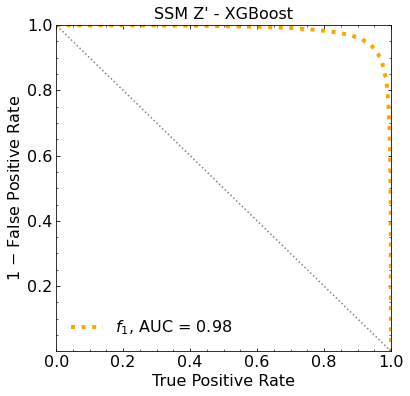

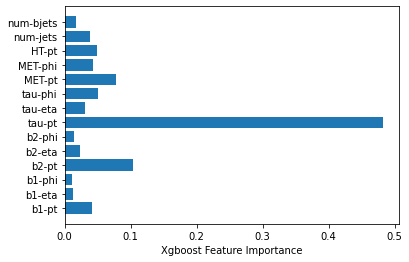

In [15]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"SSM Z' - XGBoost",fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




# THIS IS THE DEFAULT FEATURE IMPORTANCE: gain
feature_names = np.array(['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets'])
plt.barh(feature_names, classifier.feature_importances_)
plt.xlabel("Xgboost Feature Importance")
plt.show()

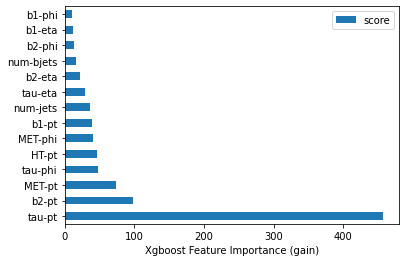

In [16]:
keys = np.array(['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets'])

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh') ## plot top 20 features
plt.xlabel("Xgboost Feature Importance (gain)")
plt.show()

Classification score:


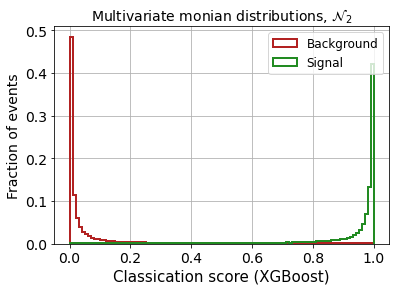

In [17]:
# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate monian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

## METHODS

### 0. Ensembles characteristics

In [9]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = round(139 * totalcrossSM)    # luminosity * cross * aceptance
print('B_expected: ', B_expected)

print('S_expected: ', round(139 * crossfidNP))    # luminosity * cross * aceptance
S_expected = [10,20,50,70,100,150,200,250]




# SOME USEFUL DERIVATED PARAMETERS:

# S/\sqrt{B}
SB_ratio = [ S_expected[iii]/(1.*B_expected) for iii in range(len(S_expected)) ]

# S/\sqrt{B}
SsqrtB = [ S_expected[iii]/(B_expected)**0.5 for iii in range(len(S_expected)) ]

B_expected:  1428
S_expected:  180


In [10]:
139 * crossfidNP

179.70491444028997

### 1. BIN LOG LIKELIHOOD

B_expected:  1428
S_expected:  10
S/$\sqrt{B}$:  0.26462806201248157

 If  287  =  176    then the proposed range has to be extended
n_ensembles (actual):  1867

 This may take a bit... 



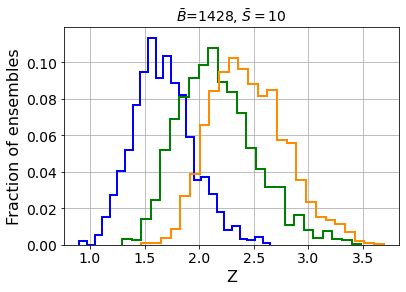

Z_bins_16bins:  1.6582917243773705
Z_bins_16bins_std:  0.2734605058515336
Z_bins_50bins:  2.1321147691083095
Z_bins_50bins_std:  0.356351651335157
Z_bins_100bins:  2.427000642916698
Z_bins_100bins_std:  0.34582819389605457

 -------------------------------- 

B_expected:  1428
S_expected:  20
S/$\sqrt{B}$:  0.5292561240249631

 If  289  =  177    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take a bit... 



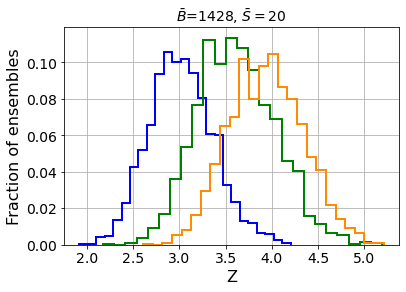

Z_bins_16bins:  3.008680466081324
Z_bins_16bins_std:  0.3467841164687621
Z_bins_50bins:  3.595364333721846
Z_bins_50bins_std:  0.420700220363226
Z_bins_100bins:  3.941356301640713
Z_bins_100bins_std:  0.39766153652137626

 -------------------------------- 

B_expected:  1428
S_expected:  50
S/$\sqrt{B}$:  1.3231403100624077

 If  295  =  178    then the proposed range has to be extended
n_ensembles (actual):  1863

 This may take a bit... 



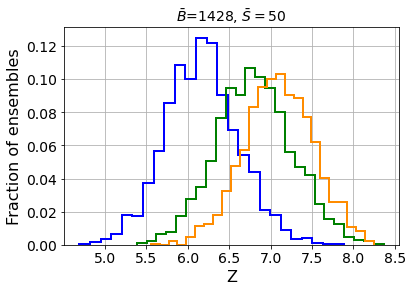

Z_bins_16bins:  6.1630336938301555
Z_bins_16bins_std:  0.4388396005099768
Z_bins_50bins:  6.799160248913813
Z_bins_50bins_std:  0.46112526189515046
Z_bins_100bins:  7.098407599441866
Z_bins_100bins_std:  0.41470954074002364

 -------------------------------- 

B_expected:  1428
S_expected:  70
S/$\sqrt{B}$:  1.8523964340873709

 If  299  =  179    then the proposed range has to be extended
n_ensembles (actual):  1871

 This may take a bit... 



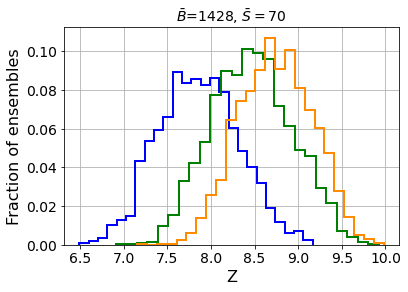

Z_bins_16bins:  7.843278485103517
Z_bins_16bins_std:  0.45679020445078716
Z_bins_50bins:  8.45881209292473
Z_bins_50bins_std:  0.4637208832819871
Z_bins_100bins:  8.736860977070378
Z_bins_100bins_std:  0.4180376795738736

 -------------------------------- 

B_expected:  1428
S_expected:  100
S/$\sqrt{B}$:  2.6462806201248155

 If  305  =  180    then the proposed range has to be extended
n_ensembles (actual):  1870

 This may take a bit... 



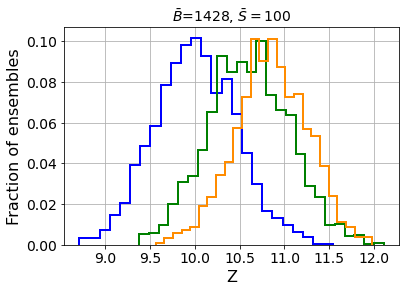

Z_bins_16bins:  9.997281983152167
Z_bins_16bins_std:  0.45305018543629333
Z_bins_50bins:  10.598985443181387
Z_bins_50bins_std:  0.45444358510915567
Z_bins_100bins:  10.855414375441281
Z_bins_100bins_std:  0.4044391058707977

 -------------------------------- 

B_expected:  1428
S_expected:  150
S/$\sqrt{B}$:  3.969420930187223

 If  315  =  183    then the proposed range has to be extended
n_ensembles (actual):  1867

 This may take a bit... 



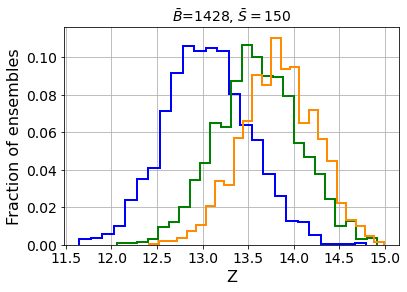

Z_bins_16bins:  13.039446492128342
Z_bins_16bins_std:  0.46629234008341225
Z_bins_50bins:  13.599362431757475
Z_bins_50bins_std:  0.456083972299039
Z_bins_100bins:  13.835638039487934
Z_bins_100bins_std:  0.40776103845758815

 -------------------------------- 

B_expected:  1428
S_expected:  200
S/$\sqrt{B}$:  5.292561240249631

 If  325  =  186    then the proposed range has to be extended
n_ensembles (actual):  1861

 This may take a bit... 



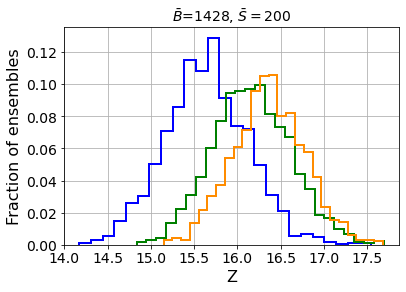

Z_bins_16bins:  15.646612426894235
Z_bins_16bins_std:  0.4761259876931723
Z_bins_50bins:  16.157159079899493
Z_bins_50bins_std:  0.4533165122555471
Z_bins_100bins:  16.362159781261827
Z_bins_100bins_std:  0.4141169976744856

 -------------------------------- 

B_expected:  1428
S_expected:  250
S/$\sqrt{B}$:  6.615701550312039

 If  335  =  188    then the proposed range has to be extended
n_ensembles (actual):  1862

 This may take a bit... 



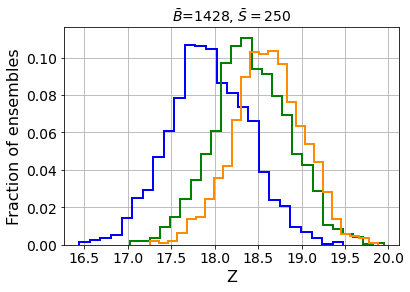

Z_bins_16bins:  17.917348934162924
Z_bins_16bins_std:  0.46633060185855635
Z_bins_50bins:  18.406362953220288
Z_bins_50bins_std:  0.4460892567173387
Z_bins_100bins:  18.615567645908307
Z_bins_100bins_std:  0.4059081372470427

 -------------------------------- 



In [20]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_Z_bins_XG_16bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []

store_Z_bins_XG_16bins_std = []
store_Z_bins_XG_50bins_std = []
store_Z_bins_XG_100bins_std = []

# store_Z_bins_XG_16bins_noUnc = []
# store_Z_bins_XG_50bins_noUnc = []
# store_Z_bins_XG_100bins_noUnc = []

# store_Z_bins_XG_16bins_noUnc_std = []
# store_Z_bins_XG_50bins_noUnc_std = []
# store_Z_bins_XG_100bins_noUnc_std = []


indices_B = [i for i in range(len(pred_XG_SM))]
indices_S = [i for i in range(len(pred_XG_NP))]







for iii in range(len(S_expected)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    
    
    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######
    
    
    print('\n This may take a bit... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    Z_bins_16bins_aux = []
    Z_bins_50bins_aux = []
    Z_bins_100bins_aux = []
    
#     Z_bins_16bins_noUnc_aux = []
#     Z_bins_50bins_noUnc_aux = []
#     Z_bins_100bins_noUnc_aux = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            ran_ind_B = np.random.choice(indices_B, list_B_per_ensembles[bb])
            ran_ind_S = np.random.choice(indices_S, list_S_per_ensembles[bb])
            

            
            pred_XG_SM_shuf = []
            
            pred_XG_NP_shuf = []
            
            for ill in ran_ind_B:
                pred_XG_SM_shuf.append(pred_XG_SM[ill])
                
            for ill in ran_ind_S:
                pred_XG_NP_shuf.append(pred_XG_NP[ill])
                
            
            
            ############
            # 16 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:       

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(16), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(16), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
            ## then the signif Z^binned-Asimov without uncertainties:
            Z_bins_16bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

            Z_bins_16bins_aux.append(Z_bins_16bins)
                    

#             # then the signif Z^binned-Asimov with uncertainties in the background:

#             B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_16bins**2))/((back_prom_sig_16bins**2)+back_prom) ))**0.5 )

#             Z_bins_16bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) - ( (back_prom**2/(back_prom_sig_16bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_16bins**2))) ) + sig_prom ) )**0.5

#             Z_bins_16bins_aux.append(Z_bins_16bins_sig)
            
            
            
            
            
            ############
            # 50 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(50), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(50), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
            ## then the signif Z^binned-Asimov without uncertainties:
            Z_bins_50bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

            Z_bins_50bins_aux.append(Z_bins_50bins)
                    

#             # then the signif Z^binned-Asimov with uncertainties in the background:

#             B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_50bins**2))/((back_prom_sig_50bins**2)+back_prom) ))**0.5 )

#             Z_bins_50bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) - ( (back_prom**2/(back_prom_sig_50bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_50bins**2))) ) + sig_prom ) )**0.5

#             Z_bins_50bins_aux.append(Z_bins_50bins_sig)
        
        
        
        
        
        
            ############
            # 100 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(100), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(100), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
            ## then the signif Z^binned-Asimov without uncertainties:
            Z_bins_100bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

            Z_bins_100bins_aux.append(Z_bins_100bins)
                    

#             # then the signif Z^binned-Asimov with uncertainties in the background:

#             B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_100bins**2))/((back_prom_sig_100bins**2)+back_prom) ))**0.5 )

#             Z_bins_100bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) - ( (back_prom**2/(back_prom_sig_100bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_100bins**2))) ) + sig_prom ) )**0.5

#             Z_bins_100bins_aux.append(Z_bins_100bins_sig)
            
    
    
    
  
    # Histogram of q_muhats

    weights = np.ones_like(Z_bins_16bins_aux)/float(len(Z_bins_16bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_16bins_aux, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    weights = np.ones_like(Z_bins_50bins_aux)/float(len(Z_bins_50bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_50bins_aux, 25, weights=weights, histtype='step', color='green', linewidth=2)
    weights = np.ones_like(Z_bins_100bins_aux)/float(len(Z_bins_100bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_100bins_aux, 25, weights=weights, histtype='step', color='darkorange', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Z",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()
    
    
    # 16 bins #
    # Remove nan if any
    Z_bins_16bins_aux = [x for x in Z_bins_16bins_aux if x == x]
    for jk in range(len(Z_bins_16bins_aux)):
        if Z_bins_16bins_aux[jk] < 0:
            Z_bins_16bins_aux[jk] = 0

    Z_bins_16bins = np.median(Z_bins_16bins_aux)   
    store_Z_bins_XG_16bins.append(Z_bins_16bins)
    
    Z_bins_16bins_std = np.std(Z_bins_16bins_aux)   
    store_Z_bins_XG_16bins_std.append(Z_bins_16bins_std)

    print('Z_bins_16bins: ', Z_bins_16bins)
    print('Z_bins_16bins_std: ', Z_bins_16bins_std)

    
#     # Remove nan if any
#     Z_bins_16bins_noUnc_aux = [x for x in Z_bins_16bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_16bins_noUnc_aux)):
#         if Z_bins_16bins_noUnc_aux[jk] < 0:
#             Z_bins_16bins_noUnc_aux[jk] = 0

#     Z_bins_16bins_noUnc = np.median(Z_bins_16bins_noUnc_aux)   
#     store_Z_bins_XG_16bins_noUnc.append(Z_bins_16bins_noUnc)
    
#     Z_bins_16bins_noUnc_std = np.std(Z_bins_16bins_noUnc_aux)   
#     store_Z_bins_XG_16bins_noUnc_std.append(Z_bins_16bins_noUnc_std)

#     print('Z_bins_16bins_noUnc: ', Z_bins_16bins_noUnc)
#     print('Z_bins_16bins_noUnc_std: ', Z_bins_16bins_noUnc_std)
    
    
    # 50 bins #
    # Remove nan if any
    Z_bins_50bins_aux = [x for x in Z_bins_50bins_aux if x == x]
    for jk in range(len(Z_bins_50bins_aux)):
        if Z_bins_50bins_aux[jk] < 0:
            Z_bins_50bins_aux[jk] = 0

    Z_bins_50bins = np.median(Z_bins_50bins_aux)   
    store_Z_bins_XG_50bins.append(Z_bins_50bins)
    
    Z_bins_50bins_std = np.std(Z_bins_50bins_aux)   
    store_Z_bins_XG_50bins_std.append(Z_bins_50bins_std)

    print('Z_bins_50bins: ', Z_bins_50bins)
    print('Z_bins_50bins_std: ', Z_bins_50bins_std)
    
    
#     # Remove nan if any
#     Z_bins_50bins_noUnc_aux = [x for x in Z_bins_50bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_50bins_noUnc_aux)):
#         if Z_bins_50bins_noUnc_aux[jk] < 0:
#             Z_bins_50bins_noUnc_aux[jk] = 0

#     Z_bins_50bins_noUnc = np.median(Z_bins_50bins_noUnc_aux)   
#     store_Z_bins_XG_50bins_noUnc.append(Z_bins_50bins_noUnc)
    
#     Z_bins_50bins_noUnc_std = np.std(Z_bins_50bins_noUnc_aux)   
#     store_Z_bins_XG_50bins_noUnc_std.append(Z_bins_50bins_noUnc_std)

#     print('Z_bins_50bins_noUnc: ', Z_bins_50bins_noUnc)
#     print('Z_bins_50bins_noUnc_std: ', Z_bins_50bins_noUnc_std)
    
    
    # 100 bins #
    # Remove nan if any
    Z_bins_100bins_aux = [x for x in Z_bins_100bins_aux if x == x]
    for jk in range(len(Z_bins_100bins_aux)):
        if Z_bins_100bins_aux[jk] < 0:
            Z_bins_100bins_aux[jk] = 0

    Z_bins_100bins = np.median(Z_bins_100bins_aux)   
    store_Z_bins_XG_100bins.append(Z_bins_100bins)
    
    Z_bins_100bins_std = np.std(Z_bins_100bins_aux)   
    store_Z_bins_XG_100bins_std.append(Z_bins_100bins_std)

    print('Z_bins_100bins: ', Z_bins_100bins)
    print('Z_bins_100bins_std: ', Z_bins_100bins_std)
    
    
#     # Remove nan if any
#     Z_bins_100bins_noUnc_aux = [x for x in Z_bins_100bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_100bins_noUnc_aux)):
#         if Z_bins_100bins_noUnc_aux[jk] < 0:
#             Z_bins_100bins_noUnc_aux[jk] = 0

#     Z_bins_100bins_noUnc = np.median(Z_bins_100bins_noUnc_aux)   
#     store_Z_bins_XG_100bins_noUnc.append(Z_bins_100bins_noUnc)
    
#     Z_bins_100bins_noUnc_std = np.std(Z_bins_100bins_noUnc_aux)   
#     store_Z_bins_XG_100bins_noUnc_std.append(Z_bins_100bins_noUnc_std)

#     print('Z_bins_100bins_noUnc: ', Z_bins_100bins_noUnc)
#     print('Z_bins_100bins_noUnc_std: ', Z_bins_100bins_noUnc_std)

    print('\n -------------------------------- \n')

In [21]:
print(store_Z_bins_XG_16bins)
print(store_Z_bins_XG_50bins)
print(store_Z_bins_XG_100bins)

print(store_Z_bins_XG_16bins_std)
print(store_Z_bins_XG_50bins_std)
print(store_Z_bins_XG_100bins_std)

[1.6582917243773705, 3.008680466081324, 6.1630336938301555, 7.843278485103517, 9.997281983152167, 13.039446492128342, 15.646612426894235, 17.917348934162924]
[2.1321147691083095, 3.595364333721846, 6.799160248913813, 8.45881209292473, 10.598985443181387, 13.599362431757475, 16.157159079899493, 18.406362953220288]
[2.427000642916698, 3.941356301640713, 7.098407599441866, 8.736860977070378, 10.855414375441281, 13.835638039487934, 16.362159781261827, 18.615567645908307]
[0.2734605058515336, 0.3467841164687621, 0.4388396005099768, 0.45679020445078716, 0.45305018543629333, 0.46629234008341225, 0.4761259876931723, 0.46633060185855635]
[0.356351651335157, 0.420700220363226, 0.46112526189515046, 0.4637208832819871, 0.45444358510915567, 0.456083972299039, 0.4533165122555471, 0.4460892567173387]
[0.34582819389605457, 0.39766153652137626, 0.41470954074002364, 0.4180376795738736, 0.4044391058707977, 0.40776103845758815, 0.4141169976744856, 0.4059081372470427]


In [11]:
store_Z_bins_XG_16bins = [1.6582917243773705, 3.008680466081324, 6.1630336938301555, 7.843278485103517, 9.997281983152167, 13.039446492128342, 15.646612426894235, 17.917348934162924]
store_Z_bins_XG_50bins = [2.1321147691083095, 3.595364333721846, 6.799160248913813, 8.45881209292473, 10.598985443181387, 13.599362431757475, 16.157159079899493, 18.406362953220288]
store_Z_bins_XG_100bins = [2.427000642916698, 3.941356301640713, 7.098407599441866, 8.736860977070378, 10.855414375441281, 13.835638039487934, 16.362159781261827, 18.615567645908307]

store_Z_bins_XG_16bins_std = [0.2734605058515336, 0.3467841164687621, 0.4388396005099768, 0.45679020445078716, 0.45305018543629333, 0.46629234008341225, 0.4761259876931723, 0.46633060185855635]
store_Z_bins_XG_50bins_std = [0.356351651335157, 0.420700220363226, 0.46112526189515046, 0.4637208832819871, 0.45444358510915567, 0.456083972299039, 0.4533165122555471, 0.4460892567173387]
store_Z_bins_XG_100bins_std =[0.34582819389605457, 0.39766153652137626, 0.41470954074002364, 0.4180376795738736, 0.4044391058707977, 0.40776103845758815, 0.4141169976744856, 0.4059081372470427]

In [12]:
store_Z_bins_XG_16bins_plus = [i+j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]
store_Z_bins_XG_16bins_min = [i-j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]

store_Z_bins_XG_50bins_plus = [i+j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]
store_Z_bins_XG_50bins_min = [i-j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]

store_Z_bins_XG_100bins_plus = [i+j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]
store_Z_bins_XG_100bins_min = [i-j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]

In [13]:
store_muhat_mean_16bins = [-0.0026149992966790843, 0.0035172122529438404, 0.0025946055550326655, 0.00408586506151526, 0.0006028038029432836, 0.00010765734064194548, -0.0005421209727063707, -0.0004182507702852692]

store_Z_bins_XG_16bins_q = [1.688108988512128, 3.034596626634992, 6.112997751989363, 7.781635813076836, 9.948398484463457, 12.985913375762843, 15.606821287018425, 17.871363305329588]
store_Z_bins_XG_16bins_std = [0.7087517235930267, 0.7558150293519545, 0.7444374165434563, 0.7359550703943974, 0.6656263823804167, 0.6474994621765884, 0.6190464523955865, 0.6067405010675817]

store_Z_bins_XG_16bins_mu0 = [1.688108988512128, 3.034596626634992, 6.112997751989363, 7.7812772624957205, 9.948398484463457, 12.985826994673317, 15.606821287018425, 17.870881940996924]
store_Z_bins_XG_16bins_std_mu0 = [0.7415284190925815, 0.828611978853726, 0.8079515320432588, 0.7908397823346658, 0.7012260129378824, 0.6771000781488243, 0.6419992001009618, 0.628109233551799]

In [14]:
store_Z_bins_XG_16bins_plus = [i+j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]
store_Z_bins_XG_16bins_min = [i-j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]

store_Z_bins_XG_50bins_plus = [i+j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]
store_Z_bins_XG_50bins_min = [i-j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]

store_Z_bins_XG_100bins_plus = [i+j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]
store_Z_bins_XG_100bins_min = [i-j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]

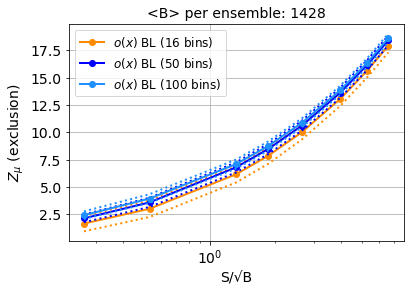

In [15]:
#########
# PLOTS #
#########

posX = []

for i in range(len(S_expected)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )


    
plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_plus, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_16bins_min, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins_plus, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins_min, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins_plus, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins_min, ':', color='dodgerblue', lw=lw) 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### MLL KDE

#### KDE

/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  8729.72988892  8583.52520399
  8358.66079129  8038.22299899  7611.65989935  7054.53162858
  6364.37298294  5536.43885415  4569.21129289  3490.59776196
  2280.1976416    955.06154448  -460.57715056 -1898.19355938]
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:961: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.0019008479046983867, kernel='epanechnikov')


/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  7798.68086194
  7659.91686135  7425.26194558  7086.60650685  6630.742991
  6042.00661031  5311.5931398   4434.11247627  3426.56904545
  2287.52060855  1002.14340015  -394.71281586 -1866.22830003]
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:961: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.0031053121543406503, kernel='epanechnikov')


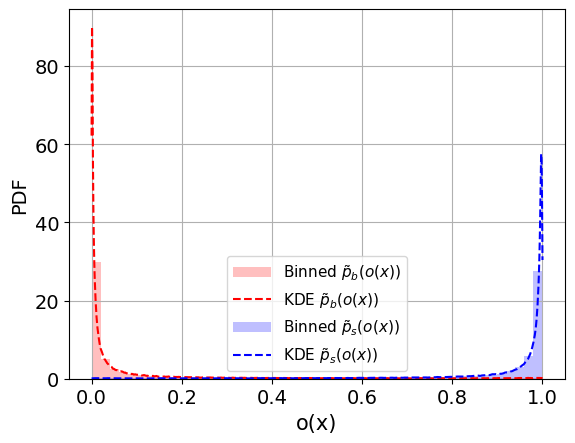

In [24]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs



# # FIND THE BANDWIDTH

#SM_bandwidth = 0.0127
#NP_bandwidth = 0.0127

bandwidth = np.logspace(-4.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:20000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth



kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:20000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth



# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])



# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
#plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

B_expected:  1428


/tmp/ipykernel_12758/4108206064.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_16bins, '-ok', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
/tmp/ipykernel_12758/4108206064.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_50bins, '-ok', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
/tmp/ipykernel_12758/4108206064.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_100bins, '-ok', color='red', lw=lw, label=r'$o(x)$ BL (100 bins)')


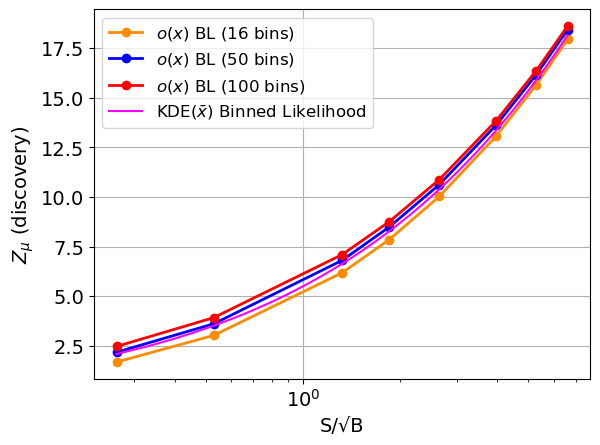

In [25]:
# We can do a quick Z bin-loglikelihood calculation using the computed KDE
# this is to check the KDE here, because we use KDE to avoid binning


# in each ensemble we use B=50k
print('B_expected: ', B_expected)

# values of S / sqrt{B} to test 
soversqrtB = np.linspace(SsqrtB[0],SsqrtB[-1],100)



# Let's find out the expected number of B and S events in each bin:

# total number of B * B_pdf value in each bin * bin size
Bd = B_expected*dens_bkg*(s_vals[1]-s_vals[0])



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
Bd_noceros = []
for i in range(len(Bd)):
    if Bd[i]!=0:
        Bd_noceros.append(Bd[i])

min_back = min(Bd_noceros)

# replace the zeros
for i in range(len(Bd)):
    if Bd[i]==0:
        Bd[i] = min_back




# Now calculate Z using the Binned Likelihood formula

Zvals = np.zeros(len(soversqrtB))

for nval, val in enumerate(soversqrtB):
    # S events in each bin: 
    # value of S/sqrt{B} * sqrt{B} * S_pdf value in each bin * bin size
    Sd = val*np.sqrt(B_expected)*dens_sig*(s_vals[1]-s_vals[0])
    
    # Z value:
    #Zvals[nval]= np.sqrt(2.0*np.sum(((Sd+Bd)*np.log(1.0+Sd/Bd)-Sd))) # Discovery
    Zvals[nval]= np.sqrt(2.0*np.sum(Bd*np.log(Bd/(Sd+Bd))+Sd)) # Exclusion

    
    
    
# PLOT

plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='red', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(soversqrtB, Zvals, color='magenta', label=r'KDE$(\bar{x})$ Binned Likelihood') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

#### MLL KDE

In [26]:
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

In [27]:
KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )


# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

B_expected:  1428
S_expected:  10
S/$\sqrt{B}$:  0.26462806201248157
n_ensembles (initial):  2000

 If  287  =  176    then the proposed range has to be extended
n_ensembles (actual):  1867

 This may take long... 



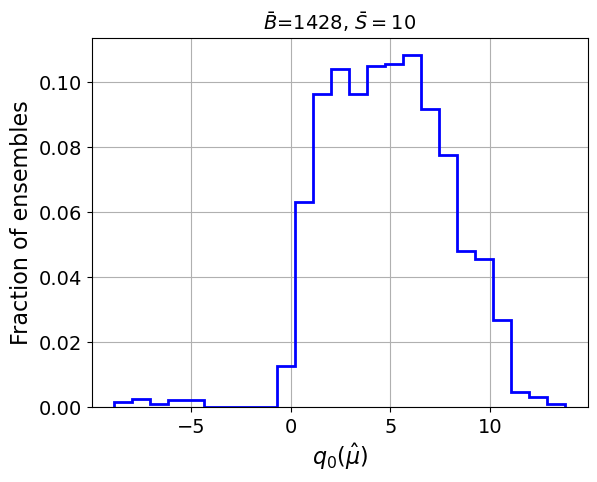

muhat mean:  0.1260310658810927
median q_muhat_KDE:  4.823050107550074
Z_KDE:  2.1961443731116757
Z_KDE mu=0:  2.19407434931522
std Z_KDE:  0.6410793930242257
std Z_KDE mu=0:  0.6918246915274713

 -------------------------------- 

B_expected:  1428
S_expected:  20
S/$\sqrt{B}$:  0.5292561240249631
n_ensembles (initial):  2000

 If  289  =  177    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take long... 



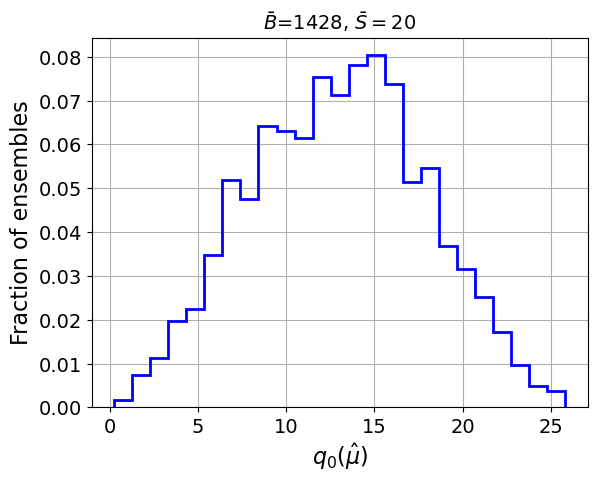

muhat mean:  0.07957708779443257
median q_muhat_KDE:  13.031898737214123
Z_KDE:  3.6099721241602576
Z_KDE mu=0:  3.6120014573928727
std Z_KDE:  0.6811993490367466
std Z_KDE mu=0:  0.7594753799991492

 -------------------------------- 

B_expected:  1428
S_expected:  50
S/$\sqrt{B}$:  1.3231403100624077
n_ensembles (initial):  2000

 If  295  =  178    then the proposed range has to be extended
n_ensembles (actual):  1863

 This may take long... 



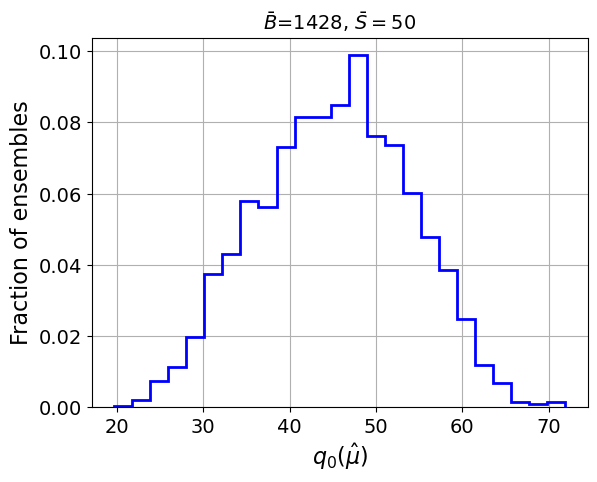

muhat mean:  0.037278582930756844
median q_muhat_KDE:  45.446682565258946
Z_KDE:  6.741415471936064
Z_KDE mu=0:  6.741415471936064
std Z_KDE:  0.6491870441817231
std Z_KDE mu=0:  0.6911389694980719

 -------------------------------- 

B_expected:  1428
S_expected:  70
S/$\sqrt{B}$:  1.8523964340873709
n_ensembles (initial):  2000

 If  299  =  179    then the proposed range has to be extended
n_ensembles (actual):  1871

 This may take long... 



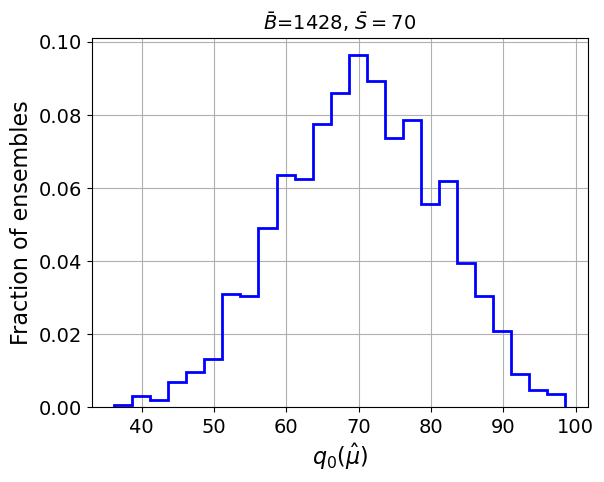

muhat mean:  0.02990379476215927
median q_muhat_KDE:  70.27553041533679
Z_KDE:  8.383050185662542
Z_KDE mu=0:  8.390477570917136
std Z_KDE:  0.635605056873336
std Z_KDE mu=0:  0.6671737512169209

 -------------------------------- 

B_expected:  1428
S_expected:  100
S/$\sqrt{B}$:  2.6462806201248155
n_ensembles (initial):  2000

 If  305  =  180    then the proposed range has to be extended
n_ensembles (actual):  1870

 This may take long... 



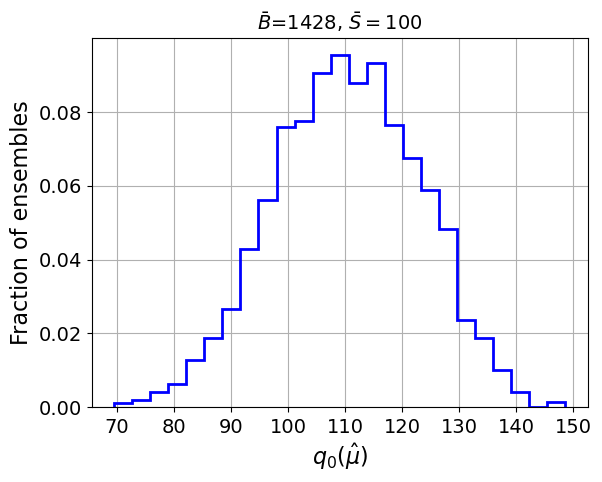

muhat mean:  0.0236096256684492
median q_muhat_KDE:  110.27679423974968
Z_KDE:  10.50127583866597
Z_KDE mu=0:  10.515455439943382
std Z_KDE:  0.6055052993636784
std Z_KDE mu=0:  0.6253454276930074

 -------------------------------- 

B_expected:  1428
S_expected:  150
S/$\sqrt{B}$:  3.969420930187223
n_ensembles (initial):  2000

 If  315  =  183    then the proposed range has to be extended
n_ensembles (actual):  1867

 This may take long... 



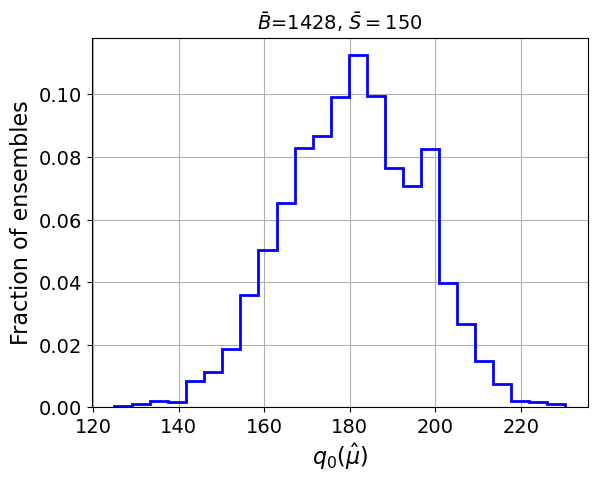

muhat mean:  0.021585431173004817
median q_muhat_KDE:  181.14302893141925
Z_KDE:  13.458938625739373
Z_KDE mu=0:  13.482437820774006
std Z_KDE:  0.5784753237994444
std Z_KDE mu=0:  0.5886670661005392

 -------------------------------- 

B_expected:  1428
S_expected:  200
S/$\sqrt{B}$:  5.292561240249631
n_ensembles (initial):  2000

 If  325  =  186    then the proposed range has to be extended
n_ensembles (actual):  1861

 This may take long... 



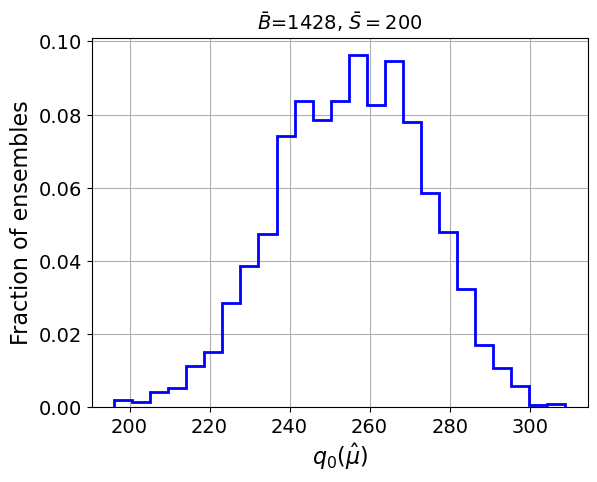

muhat mean:  0.02090274046211714
median q_muhat_KDE:  255.85266226381376
Z_KDE:  15.995395033065416
Z_KDE mu=0:  16.0293845192631
std Z_KDE:  0.5665923082477741
std Z_KDE mu=0:  0.5680816040825332

 -------------------------------- 

B_expected:  1428
S_expected:  250
S/$\sqrt{B}$:  6.615701550312039
n_ensembles (initial):  2000

 If  335  =  188    then the proposed range has to be extended
n_ensembles (actual):  1862

 This may take long... 



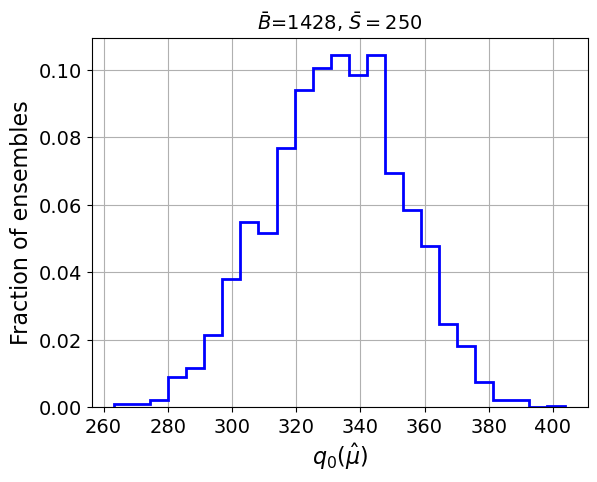

muhat mean:  0.020569280343716433
median q_muhat_KDE:  332.6507100215161
Z_KDE:  18.23871459345521
Z_KDE mu=0:  18.2941888955688
std Z_KDE:  0.5704263151220809
std Z_KDE mu=0:  0.5641667903052677

 -------------------------------- 



In [28]:
store_muhat_mean_MLL_KDE = []

store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []

store_Z_MLL_KDE_std = []
store_Z_MLL_KDE_std_mu0 = []


indices = [i for i in range(len(KDE_NP_pred_SM))]


for iii in range(len(SB_ratio)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)


    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######



    print('\n This may take long... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)





            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )



            

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_KDE = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break


            muhat_selected_KDE_list.append(muhat_selected_KDE)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected[iii]) + sum( [np.log( 1 + ( (1.*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (0.*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    
    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]
    for jk in range(len(q_muhat_KDE_mu0)):
        if q_muhat_KDE_mu0[jk] < 0:
            q_muhat_KDE_mu0[jk] = 0

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)
    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)
    
    q_muhat_KDE_std_mu0 = np.std(q_muhat_KDE_mu0)
    Z_KDE_std_mu0 = q_muhat_KDE_std_mu0/(2.*Z_KDE_mu0)
    store_Z_MLL_KDE_std_mu0.append(Z_KDE_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]
    for jk in range(len(q_muhat_KDE)):
        if q_muhat_KDE[jk] < 0:
            q_muhat_KDE[jk] = 0

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)
    
    q_muhat_KDE_std = np.std(q_muhat_KDE)
    Z_KDE_std = q_muhat_KDE_std/(2.*Z_KDE)
    store_Z_MLL_KDE_std.append(Z_KDE_std)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)
    print('std Z_KDE: ', Z_KDE_std)
    print('std Z_KDE mu=0: ', Z_KDE_std_mu0)

    print('\n -------------------------------- \n')

In [29]:
print(store_muhat_mean_MLL_KDE)

print(store_Z_MLL_KDE)
print(store_Z_MLL_KDE_mu0)

print(store_Z_MLL_KDE_std)
print(store_Z_MLL_KDE_std_mu0)

[0.1260310658810927, 0.07957708779443257, 0.037278582930756844, 0.02990379476215927, 0.0236096256684492, 0.021585431173004817, 0.02090274046211714, 0.020569280343716433]
[2.1961443731116757, 3.6099721241602576, 6.741415471936064, 8.383050185662542, 10.50127583866597, 13.458938625739373, 15.995395033065416, 18.23871459345521]
[2.19407434931522, 3.6120014573928727, 6.741415471936064, 8.390477570917136, 10.515455439943382, 13.482437820774006, 16.0293845192631, 18.2941888955688]
[0.6410793930242257, 0.6811993490367466, 0.6491870441817231, 0.635605056873336, 0.6055052993636784, 0.5784753237994444, 0.5665923082477741, 0.5704263151220809]
[0.6918246915274713, 0.7594753799991492, 0.6911389694980719, 0.6671737512169209, 0.6253454276930074, 0.5886670661005392, 0.5680816040825332, 0.5641667903052677]


In [16]:
# To use if you dont want to run everything again. Its the previous results
store_muhat_mean_MLL_KDE = [0.1260310658810927, 0.07957708779443257, 0.037278582930756844, 0.02990379476215927, 0.0236096256684492, 0.021585431173004817, 0.02090274046211714, 0.020569280343716433]

store_Z_MLL_KDE = [2.1961443731116757, 3.6099721241602576, 6.741415471936064, 8.383050185662542, 10.50127583866597, 13.458938625739373, 15.995395033065416, 18.23871459345521]
store_Z_MLL_KDE_mu0 = [2.19407434931522, 3.6120014573928727, 6.741415471936064, 8.390477570917136, 10.515455439943382, 13.482437820774006, 16.0293845192631, 18.2941888955688]

store_Z_MLL_KDE_std = [0.6410793930242257, 0.6811993490367466, 0.6491870441817231, 0.635605056873336, 0.6055052993636784, 0.5784753237994444, 0.5665923082477741, 0.5704263151220809]
store_Z_MLL_KDE_std_mu0 = [0.6918246915274713, 0.7594753799991492, 0.6911389694980719, 0.6671737512169209, 0.6253454276930074, 0.5886670661005392, 0.5680816040825332, 0.5641667903052677]

In [17]:
store_Z_MLL_KDE_plus = [i+j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]
store_Z_MLL_KDE_min = [i-j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]

store_Z_MLL_KDE_mu0_plus = [i+j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]
store_Z_MLL_KDE_mu0_min = [i-j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]

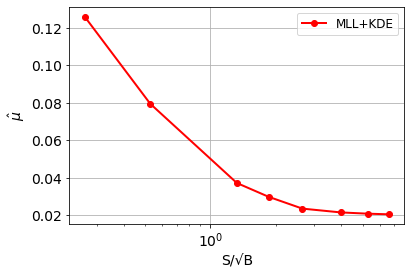

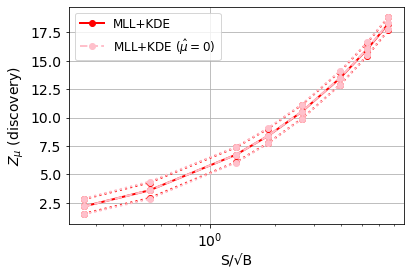

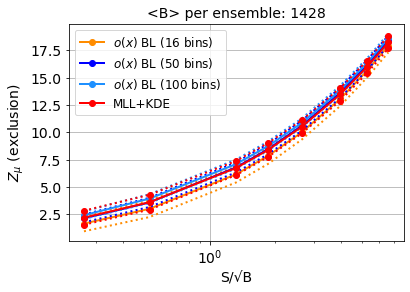

In [18]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_plus, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_min, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_mu0, '--o', color='pink', lw=lw, label=r'MLL+KDE ($\hat{\mu}=0$)')
plt.plot(posX, store_Z_MLL_KDE_mu0_plus, ':o', color='pink', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_mu0_min, ':o', color='pink', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_plus, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_16bins_min, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins_plus, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins_min, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins_plus, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins_min, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_plus, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_min, ':o', color='red', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### Interpolate

In [19]:
# if Z < 0 -> Z=0

store_Z_bins_XG_16bins = [0 if i < 0 else i for i in store_Z_bins_XG_16bins]
store_Z_bins_XG_16bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_16bins_plus]
store_Z_bins_XG_16bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_16bins_min]

store_Z_bins_XG_50bins = [0 if i < 0 else i for i in store_Z_bins_XG_50bins]
store_Z_bins_XG_50bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_50bins_plus]
store_Z_bins_XG_50bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_50bins_min]

store_Z_bins_XG_100bins = [0 if i < 0 else i for i in store_Z_bins_XG_100bins]
store_Z_bins_XG_100bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_100bins_plus]
store_Z_bins_XG_100bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_100bins_min]

store_Z_MLL_KDE = [0 if i < 0 else i for i in store_Z_MLL_KDE]
store_Z_MLL_KDE_plus = [0 if i < 0 else i for i in store_Z_MLL_KDE_plus]
store_Z_MLL_KDE_min = [0 if i < 0 else i for i in store_Z_MLL_KDE_min]

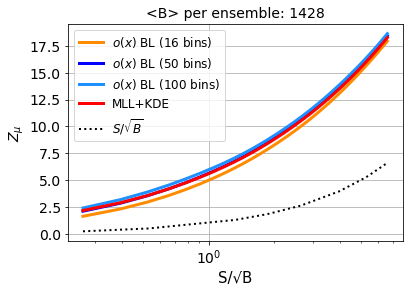

In [20]:
  
# Interpolation, cubic
f_16bins = interp1d(posX, store_Z_bins_XG_16bins, kind='cubic')
f_16bins_plus = interp1d(posX, store_Z_bins_XG_16bins_plus, kind='cubic')
f_16bins_min = interp1d(posX, store_Z_bins_XG_16bins_min, kind='cubic')

f_50bins = interp1d(posX, store_Z_bins_XG_50bins, kind='cubic')
f_50bins_plus = interp1d(posX, store_Z_bins_XG_50bins_plus, kind='cubic')
f_50bins_min = interp1d(posX, store_Z_bins_XG_50bins_min, kind='cubic')

f_100bins = interp1d(posX, store_Z_bins_XG_100bins, kind='cubic')
f_100bins_plus = interp1d(posX, store_Z_bins_XG_100bins_plus, kind='cubic')
f_100bins_min = interp1d(posX, store_Z_bins_XG_100bins_min, kind='cubic')

f_MLL_KDE = interp1d(posX, store_Z_MLL_KDE, kind='cubic')
f_MLL_KDE_plus = interp1d(posX, store_Z_MLL_KDE_plus, kind='cubic')
f_MLL_KDE_min = interp1d(posX, store_Z_MLL_KDE_min, kind='cubic')



# x to plot
plotX = np.linspace(min(posX), max(posX), num=50, endpoint=True)



plt.figure()
lw = 2

plt.plot(plotX, f_16bins(plotX), '-', color='darkorange', lw=3, label=r'$o(x)$ BL (16 bins)')
plt.plot(plotX, f_50bins(plotX), '-', color='blue', lw=3, label=r'$o(x)$ BL (50 bins)')
plt.plot(plotX, f_100bins(plotX), '-', color='dodgerblue', lw=3, label=r'$o(x)$ BL (100 bins)')
plt.plot(plotX, f_MLL_KDE(plotX), '-', color='red', lw=3, label='MLL+KDE')
plt.plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')

#plt.ylim([0., 6])
#plt.xlim([0.06, 10])
#plt.ylim([0., 3])
#plt.xlim([0.1, 0.2])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=15)
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [21]:
# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solve(fn, value, x=0.1, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

In [22]:
# We need the ratio of the fiducial cross-sections for different values of beta to rescale

beta = [0,0.1,0.3,0.5,0.7,0.9,1]

# m_LQ = [ 800, 1000, 1200, 1400, 1600, 1800 ]  GeV
ind_mass = 0

fidcross_beta00 = [0.1271808, 0.027032160000000003, 0.00770688, 0.001878312, 0.0005908139999999999, 0.00017041759999999998]
fidcross_beta01 = [0.3163628, 0.0741753, 0.01952626, 0.0044892, 0.0016499700000000002, 0.00046830800000000007]
fidcross_beta03 = [0.559062, 0.13798409999999997, 0.03652792, 0.01062024, 0.002733768, 0.0008702760000000001]
fidcross_beta05 = [0.74664, 0.1822585, 0.04825368, 0.012417530000000001, 0.0032513399999999997, 0.001112082]
fidcross_beta07 = [0.6483749999999999, 0.165285, 0.04282562, 0.01281222, 0.003864048, 0.001097392]
fidcross_beta09 = [0.43799099999999996, 0.113778, 0.03572283, 0.010101599999999999, 0.0030826390000000003, 0.0008606400000000001]
fidcross_beta1 = [0.26443679999999997, 0.08237423999999999, 0.026599559999999994, 0.007674479999999999, 0.00222552, 0.0007910968]


S00 = round(139 * crossfidNP) * (fidcross_beta00[ind_mass]/fidcross_beta05[ind_mass])
S01 = round(139 * crossfidNP) * (fidcross_beta01[ind_mass]/fidcross_beta05[ind_mass])
S03 = round(139 * crossfidNP) * (fidcross_beta03[ind_mass]/fidcross_beta05[ind_mass])
S05 = round(139 * crossfidNP) * (fidcross_beta05[ind_mass]/fidcross_beta05[ind_mass])
S07 = round(139 * crossfidNP) * (fidcross_beta07[ind_mass]/fidcross_beta05[ind_mass])
S09 = round(139 * crossfidNP) * (fidcross_beta09[ind_mass]/fidcross_beta05[ind_mass])
S1 = round(139 * crossfidNP) * (fidcross_beta1[ind_mass]/fidcross_beta05[ind_mass])


S_exp_LQ = [S00,S01,S03,S05,S07,S09,S1]

print(S_exp_LQ)

[30.66075216972035, 76.26875602700098, 134.77868852459017, 180.0, 156.31027000964318, 105.59088717454195, 63.75043394406943]


In [23]:
# Finally, the value of Z for each value of beta, for this particular LQ

results_16bins_beta = []
results_16bins_beta_plus = []
results_16bins_beta_min = []

results_50bins_beta = []
results_50bins_beta_plus = []
results_50bins_beta_min = []

results_100bins_beta = []
results_100bins_beta_plus = []
results_100bins_beta_min = []

results_MLL_KDE_beta = []
results_MLL_KDE_beta_plus = []
results_MLL_KDE_beta_min = []



for signal in S_exp_LQ:    
    results_16bins_beta.append( f_16bins(signal/(B_expected**0.5)).tolist() )
    results_16bins_beta_plus.append( f_16bins_plus(signal/(B_expected**0.5)).tolist() )
    results_16bins_beta_min.append( f_16bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_50bins_beta.append( f_50bins(signal/(B_expected**0.5)).tolist() )
    results_50bins_beta_plus.append( f_50bins_plus(signal/(B_expected**0.5)).tolist() )
    results_50bins_beta_min.append( f_50bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_100bins_beta.append( f_100bins(signal/(B_expected**0.5)).tolist() )
    results_100bins_beta_plus.append( f_100bins_plus(signal/(B_expected**0.5)).tolist() )
    results_100bins_beta_min.append( f_100bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_MLL_KDE_beta.append( f_MLL_KDE(signal/(B_expected**0.5)).tolist() )
    results_MLL_KDE_beta_plus.append( f_MLL_KDE_plus(signal/(B_expected**0.5)).tolist() )
    results_MLL_KDE_beta_min.append( f_MLL_KDE_min(signal/(B_expected**0.5)).tolist() )

In [24]:
print( results_16bins_beta )
print( results_16bins_beta_plus )
print( results_16bins_beta_min )

print( results_50bins_beta )
print( results_50bins_beta_plus )
print( results_50bins_beta_min )

print( results_100bins_beta )
print( results_100bins_beta_plus )
print( results_100bins_beta_min )

print( results_MLL_KDE_beta )
print( results_MLL_KDE_beta_plus )
print( results_MLL_KDE_beta_min )

np.savetxt('saved-results/LQdown800GeV.txt', [results_16bins_beta,
                                            results_16bins_beta_plus,
                                            results_16bins_beta_min,
                                            results_50bins_beta,
                                            results_50bins_beta_plus,
                                            results_50bins_beta_min,
                                            results_100bins_beta,
                                            results_100bins_beta_plus,
                                            results_100bins_beta_min,
                                            results_MLL_KDE_beta,
                                            results_MLL_KDE_beta_plus,
                                            results_MLL_KDE_beta_min])

[4.257719147620971, 8.32457680951509, 12.167671611481703, 14.647949634988173, 13.389391910154647, 10.365344744942373, 7.343004645500438]
[5.023595104302417, 9.050232546716868, 12.812546665212231, 15.28263213336319, 14.03621845536837, 11.021317498270964, 8.08325745038365]
[3.4918431909395253, 7.598921072313312, 11.522796557751175, 14.013267136613154, 12.74256536494092, 9.709371991613782, 6.602751840617224]
[4.896389552701953, 8.936215057853941, 12.742969332926695, 15.176784618369771, 13.94269910963667, 10.964054057522322, 7.963728151839085]
[5.348834464339377, 9.399107919193138, 13.197104717201757, 15.632602441047084, 14.3992080929064, 11.417257136927885, 8.426934397187479]
[4.44394464106453, 8.473322196514742, 12.288833948651629, 14.720966795692458, 13.48619012636694, 10.510850978116759, 7.500521906490692]
[5.244580032778482, 9.210078210448144, 12.985296857113225, 15.394181922673685, 14.175619987971809, 11.217316866535981, 8.245573106399233]
[5.662479933671417, 9.627129730479922, 13.38

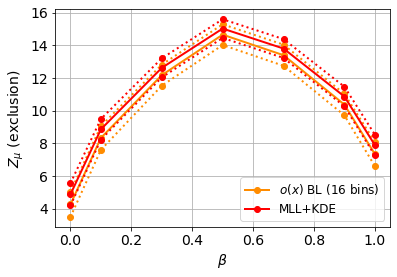

In [25]:
plt.figure()
lw = 2

plt.plot(beta, results_16bins_beta, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
plt.plot(beta, results_16bins_beta_plus, ':o', color='darkorange', lw=lw) 
plt.plot(beta, results_16bins_beta_min, ':o', color='darkorange', lw=lw) 

# plt.plot(beta, results_50bins_beta, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
# plt.plot(beta, results_50bins_beta_plus, ':o', color='blue', lw=lw) 
# plt.plot(beta, results_50bins_beta_min, ':o', color='blue', lw=lw) 

# plt.plot(beta, results_100bins_beta, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)')
# plt.plot(beta, results_100bins_beta_plus, ':o', color='dodgerblue', lw=lw) 
# plt.plot(beta, results_100bins_beta_min, ':o', color='dodgerblue', lw=lw) 

plt.plot(beta, results_MLL_KDE_beta, '-o', color='red', lw=lw, label=r'MLL+KDE')
plt.plot(beta, results_MLL_KDE_beta_plus, ':o', color='red', lw=lw) 
plt.plot(beta, results_MLL_KDE_beta_min, ':o', color='red', lw=lw) 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
#plt.xscale('log')
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(fontsize=12)
plt.show()